In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pywt

from compressor.wavelet_compressor import WaveletCompressor

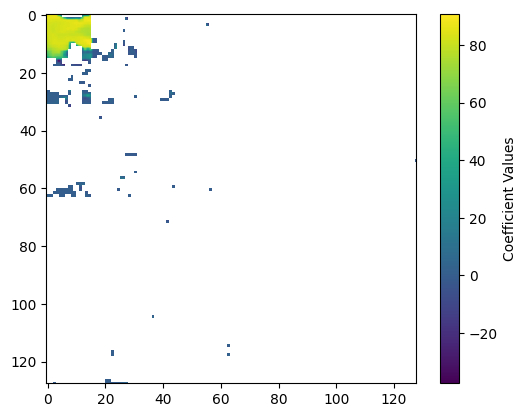

0.4670255258679421
12.710628394103956


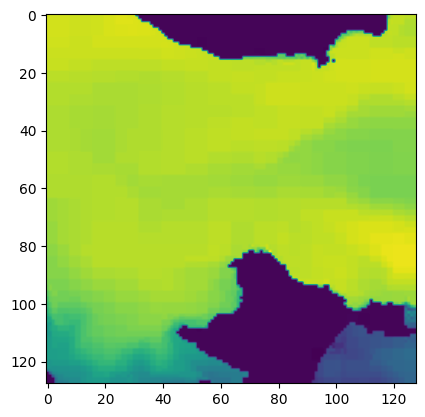

In [134]:
# Load the.npy file
data = np.load('data/raw_temperature/tt0.npy')

coeff_arr, slices = pywt.coeffs_to_array(pywt.wavedec2(data, 'db1', level=3))

coeff_arr = pywt.threshold(coeff_arr, 0.39, mode='hard', substitute=0)

plt.imshow(np.ma.masked_where(coeff_arr==0, coeff_arr))
plt.colorbar(label='Coefficient Values')
plt.show()

rec_img = pywt.waverec2(pywt.array_to_coeffs(coeff_arr, slices, output_format='wavedec2'), 'db1')
plt.imshow(rec_img)

print(np.max(np.abs(rec_img - data)))
print(128 * 128 / np.count_nonzero(coeff_arr))

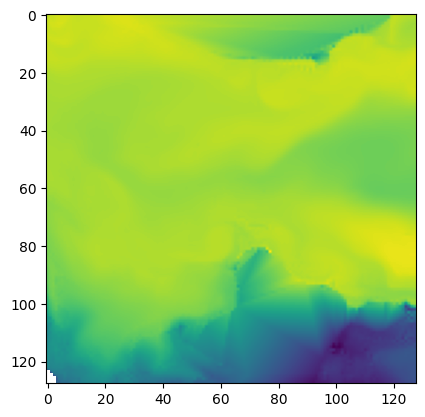

In [143]:
from scipy.interpolate import griddata

data = np.load('data/raw_temperature/tt0.npy')
masked_arr = np.ma.masked_equal(data, 0)

x = np.arange(masked_arr.shape[1])
y = np.arange(masked_arr.shape[0])
xx, yy = np.meshgrid(x, y)
x1 = xx[~masked_arr.mask]
y1 = yy[~masked_arr.mask]

# Get the values of the non-masked elements
newarr = masked_arr.data[~masked_arr.mask]

# Interpolate the missing values
interpolated_arr = griddata((x1, y1), newarr, (xx, yy), method='linear')
plt.imshow(interpolated_arr)


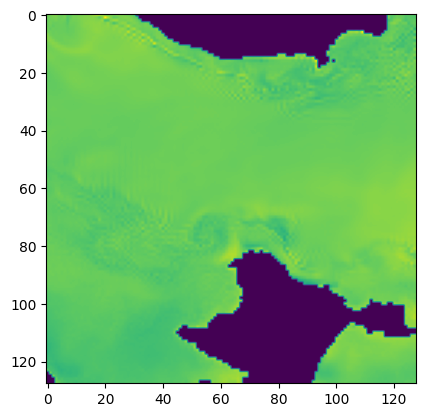

In [144]:
data1023 = np.load('data/raw_temperature/tt1023.npy')
plt.imshow(data1023)